In [18]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [19]:
df = pd.read_csv('/Users/minjeong/Downloads/WISDM.csv', index_col=0)
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [20]:
Jogging = df[df['activity']=='Jogging'].head(4500).copy()
Sitting = df[df['activity']=='Sitting'].head(4499).copy()

In [23]:
import pandas as pd
balanced_data = pd.DataFrame()
balanced_data = pd.concat([balanced_data,Jogging, Sitting])
balanced_data.shape

(8999, 6)

In [24]:
balanced_data['activity'].value_counts()

Jogging    4500
Sitting    4499
Name: activity, dtype: int64

In [28]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

balanced_data['activity']=le.fit_transform(balanced_data['activity'])

In [29]:
balanced_data['activity'].value_counts()

0    4500
1    4499
Name: activity, dtype: int64

In [31]:
from sklearn.model_selection import train_test_split



X_train, X_test = train_test_split(balanced_data, test_size=0.25, random_state=42)



X_train.shape, X_test.shape

((6749, 6), (2250, 6))

In [32]:
# Normal = 0 Fall = 1

normal = X_train[X_train['activity'] == 1]

In [33]:
y_train = normal['activity']

X_train_normal_train = normal.drop(['activity'], axis=1)


y_test = X_test['activity']

In [34]:
X_train_ft = X_train_normal_train.values

X_test = X_test.values

In [39]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [41]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
190/190 [==============================] - 1s 1ms/step - loss: 278805584116316133597904896.0000 - accuracy: 0.0000e+00 - val_loss: 258478729439870030771650560.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
190/190 [==============================] - 0s 732us/step - loss: 278805528776083912469250048.0000 - accuracy: 0.0000e+00 - val_loss: 258478729439870030771650560.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
190/190 [==============================] - 0s 729us/step - loss: 278805602563060207307456512.0000 - accuracy: 0.0000e+00 - val_loss: 258478729439870030771650560.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
190/190 [==============================] - 0s 728us/step - loss: 278805584116316133597904896.0000 - accuracy: 0.0000e+00 - val_loss: 258478729439870030771650560.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
190/190 [==============================] - 0s 714us/step - loss: 278805639456548354726559744.0000 - accuracy: 0.0000e+00 - val_loss: 258478729439870030771650560.0000 - val_acc

In [49]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

71/71 [==============================] - 0s 401us/step


,reconstruction_error,true_class
count,2.250000e+03,2250.000000
mean,2.679488e+26,0.511111
std,2.445808e+26,0.499988
min,2.547888e+25,0.000000
25%,3.656009e+25,0.000000
50%,3.712005e+25,1.000000
75%,5.160885e+26,1.000000
max,5.684351e+26,1.000000


In [60]:
threshold = 100

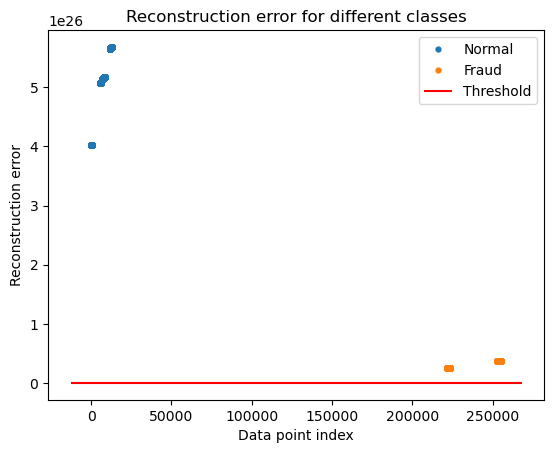

In [61]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [62]:
LABELS = ["Normal", "AbNormal"]

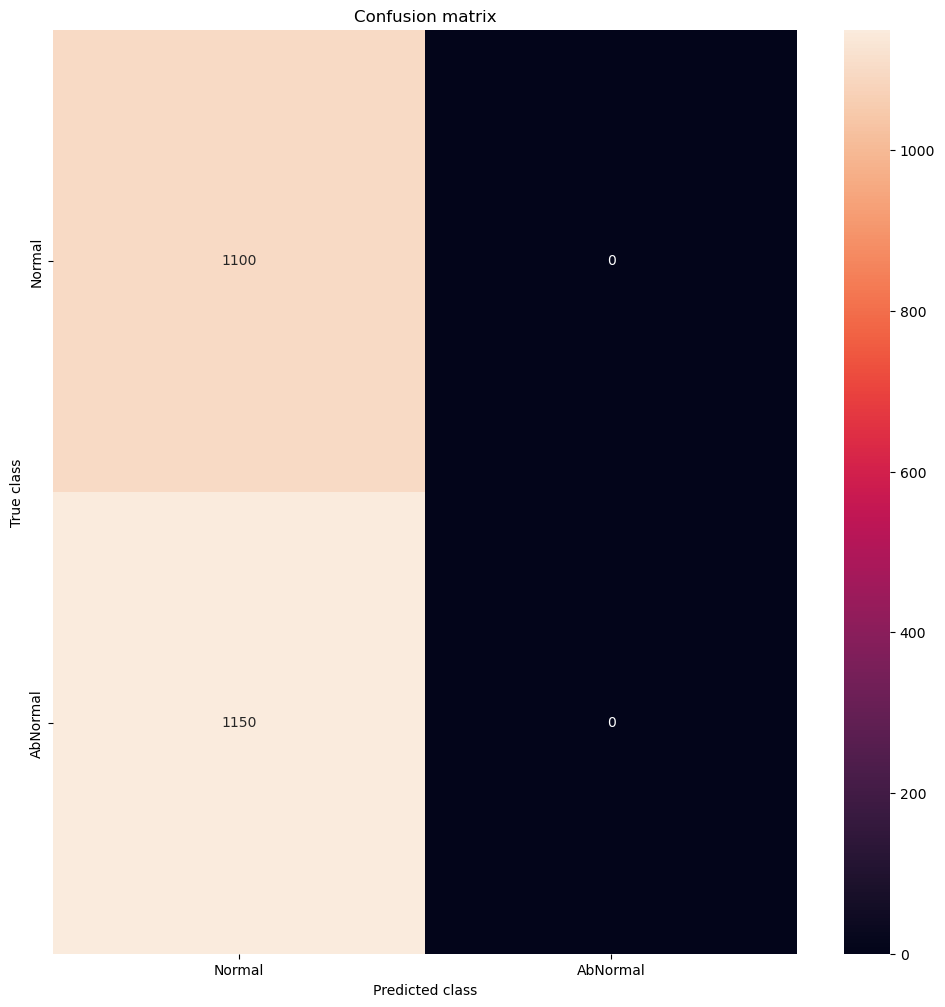

In [63]:
y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")

plt.ylabel('True class')

plt.xlabel('Predicted class')

plt.show()

In [57]:

from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )

print ('Precision :',precision )

print ('Recall :',recall )

print ('F1 :',f1 )

Accuracy Score : 0.4888888888888889
Precision : 0.0
Recall : 0.0
F1 : 0.0
